### Import packages

In [62]:
import pandas as pd
import glob
import numpy as np
import json

### Import utilities

In [63]:
import sys
sys.path.append('../src/')
import utils

z_recode_stems = utils.z_recode_stems
Recode_z = utils.Recode_z
most_common = utils.most_common
StemCode = utils.StemCode


### Import data

In [64]:
ccsr = pd.read_csv('../data/ccsr/disease_hierarchy.csv')

In [65]:
path = '../data/disease_categorization/output' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

er = pd.concat(li, axis=0, ignore_index=True)

In [66]:
deid = pd.read_csv('../data/disease_categorization/url_deid_map.csv')

### Clean categorization output

In [67]:
deid['url_deid'] = deid['url_deid'].astype(int)

In [68]:
er['url'] = er['url'].astype(int)

In [69]:
er = er.merge(deid, left_on='url', right_on='url_deid', how='left')

In [70]:
er = er[['url_y','chunks','begin','end','sent','code','results','resolutions','res_distances']]

In [71]:
er = er.rename(columns = {'url_y':'url', 'code':'entity_code'})

### Inspect data

In [72]:
er.head()

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances
0,https://www.gofundme.com/f/a-special-cause-for...,genetic progressive disease,125.0,151.0,0,Q999,Q999:::N056:::D570:::M8795:::Z148:::A244:::L12...,genetic disease:::dense deposit disease:::hb s...,9.7344:::10.0489:::10.0565:::10.1802:::10.1987...
1,https://www.gofundme.com/f/a-special-cause-for...,Niemann Pick Type C,160.0,178.0,0,E7524,E7524:::E752:::E762:::G600,"niemann-pick disease, type c:::niemann-pick di...",7.1876:::9.1346:::11.3057:::11.9872
2,https://www.gofundme.com/f/a-special-cause-for...,Niemann Pick Type C,591.0,609.0,4,E7524,E7524:::E752:::E762:::G600,"niemann-pick disease, type c:::niemann-pick di...",7.1876:::9.1346:::11.3057:::11.9872
3,https://www.gofundme.com/f/1rtjruek80,carcinoma breast cancer,192.0,214.0,1,C509,C509:::C5091:::C5061:::C5092:::C506:::D059,carcinoma of breast:::carcinoma of female brea...,5.4987:::5.6541:::6.2232:::6.4685:::6.7216:::6...
4,https://www.gofundme.com/f/2vxam3xg,Prostate Cancer.,133.0,148.0,0,C61,C61:::Z125:::D075:::Z191:::N4231:::D4959:::D40...,prostate cancer:::suspected prostate cancer:::...,6.5884:::8.6370:::9.0534:::9.2649:::9.8835:::9...


In [73]:
er.shape

(183308, 9)

In [74]:
er['entity_code'].nunique()

4779

In [75]:
er['url'].nunique()

65133

### Recode "family/personal history of" codes (start with Z80 to Z87) and recode to second code in results

In [76]:
#takes a little while
recode_fh_map = Recode_z(er, z_recode_stems)

In [77]:
#find the most common remapping and use that
recode_fh_map_lofd = pd.DataFrame(recode_fh_map).groupby('code').agg(lambda x: most_common(list(x))).reset_index().to_dict(orient='records')

recode_fh_map_dict = {}
for d in recode_fh_map_lofd:
    recode_fh_map_dict[d['code']] = d['res']

In [78]:
z_to_recode = [k for k,v in recode_fh_map_dict.items()]
pd.Series(er['entity_code'].unique()).isin(z_to_recode).sum()

60

In [79]:
60/4779

0.012554927809165096

In [80]:
#replace values
er['entity_code'].replace(recode_fh_map_dict, inplace=True)

### Match ICD codes from entity resolution with categories from CCSR

In [81]:
raw_codes = er['entity_code'].unique().tolist()

In [82]:
ccsr_codes = ccsr['icd_10_cm_code'].tolist()

In [83]:
def StemCode(code, ccsr):
    res = 0
    while res == 0:
        sub = ccsr[ccsr['icd_10_cm_code'].str.startswith(code)]
        res = sub.shape[0]
        if res > 0:
            cats = sub['ccsr_category'].value_counts().index[0]
            return code, cats
        else:
            code = code[:-1]
            if len(code) == 0:
                print('error - no code stem')
                return np.nan, np.nan

In [84]:
def GetCodeMatch(raw_codes, ccsr_codes, ccsr):

    #define results container for best match
    best_match = []

    #loop through raw codes
    for raw in raw_codes:
        #if raw code exists in CCSR as-is
        if raw in ccsr_codes:
            #no need to define best match as exact match already exists
            continue
        else:
            #see if there are any codes that start with code
            #if not, remove final character, try again
            #once codes are found, select the ccsr_cateogry that is most common
            matched_code, ccsr_cat = StemCode(raw, ccsr)
            best_match.append({'raw_code':raw, 'matched_code_stem':matched_code,'matched_ccsr_category':ccsr_cat})

    return best_match

In [85]:
best_match_map = GetCodeMatch(raw_codes, ccsr_codes, ccsr)

error - no code stem


In [87]:
best_match_map = pd.DataFrame(best_match_map).merge(ccsr[['ccsr_category','disease_category']].drop_duplicates('ccsr_category'), 
                                                    left_on='matched_ccsr_category', 
                                                    right_on='ccsr_category', 
                                                    how='left')

In [96]:
#inspect code stem error
best_match_map[best_match_map['matched_code_stem'].isna()]

,raw_code,matched_code_stem,matched_ccsr_category,ccsr_category,disease_category
483,q878,NaN,NaN,NaN,NaN


In [97]:
er[er['entity_code'] == 'q878']

,url,chunks,begin,end,sent,entity_code,results,resolutions,res_distances
12347,https://www.gofundme.com/f/baby-delaynie,Zellweger spectrum disorders,709.0,736.0,5,q878,q878:::Q878:::E7151:::E7154:::E803:::Q777:::Q1...,zellweger syndrome (disorder):::zellweger's sy...,7.2023:::7.3898:::7.4975:::8.0355:::8.4334:::9...


In [98]:
#appears to be a capitalization issue
er.loc[12347,'entity_code'] = 'Q878'

In [99]:
#rerun after correcting capitalization issue from Spark output
raw_codes = er['entity_code'].unique().tolist()
best_match_map = GetCodeMatch(raw_codes, ccsr_codes, ccsr)

No errors after running above cell

In [100]:
best_match_map = pd.DataFrame(best_match_map).merge(ccsr[['ccsr_category','int_category','disease_category']].drop_duplicates('ccsr_category'), 
                                                    left_on='matched_ccsr_category', 
                                                    right_on='ccsr_category', 
                                                    how='left')

In [356]:
best_match_map.to_csv('../data/disease_categorization/best_match_map.csv', index=False)

In [101]:
best_match_map.shape[0]

1776

In [102]:
1777/4779

0.3718351119481063

### Replace best-matched entity codes

In [357]:
#subset dataframe for those that need best matched data
er_for_best_match = er[er['entity_code'].isin(best_match_map['raw_code'].tolist())]
er_rest = er[~er['entity_code'].isin(er_for_best_match['entity_code'].tolist())]

### Merge ER data with appropriate disease categories

In [358]:
#best match
er_for_best_match = er_for_best_match.merge(best_match_map, left_on='entity_code', right_on='raw_code', how='left')
del er_for_best_match['matched_code_stem']
del er_for_best_match['matched_ccsr_category']
er_for_best_match.loc[:,'icd_10_cm_code_desc'] = ['best_match' for x in range(len(er_for_best_match))]
er_for_best_match.rename(columns={'raw_code':'icd_10_cm_code'}, inplace=True)

#exact match
er_rest = er_rest.merge(ccsr, left_on='entity_code', right_on='icd_10_cm_code', how='left')

In [359]:
#concatenate dataframes
er_final = pd.concat([er_for_best_match, er_rest])

In [360]:
print(er_final.shape)
print(er.shape)
print('\n')
print(er_final['url'].nunique())
print(er['url'].nunique())

(183308, 14)
(183308, 9)


65133
65133


### Find additional clinical entities to infer disease category

In [361]:
import sqlite3
import re

In [362]:
conn = sqlite3.connect("../data/db/gfm.db")
master = pd.read_sql_query("SELECT url,fund_description FROM master", conn)

In [363]:
def Search(df):

    r = {}

    terms = ['dialysis',
             'renal transplant',
             'kidney transplant',
             'lung transplant',
             'heart transplant',
             'heart surgery',
             'chemo',
             'chemotherapy',
             'radiation',
             'radiotherapy',
             'bone marrow transplant',
             'liver transplant']

    for term in terms:

        #define regex
        regex = r"\b{}\b".format(term)

        #apply regex search
        search = df['fund_description'].apply(lambda x: re.search(regex, x))

        #get start and end
        start = [x.start() if x != None else np.nan for x in search]
        end = [x.end() if x != None else np.nan for x in search]

        #add to results
        r[term] = {'start':start,'end':end}
    
    return r


In [364]:
search_results = Search(master) #takes about 30 seconds

In [365]:
def SearchToDF(search_results):

    r = []

    for k,v in search_results.items():

        new_df = pd.DataFrame({'url':master['url'].tolist(),'begin':v['start'],'end':v['end']})

        new_df = new_df.dropna()

        new_df['chunks'] = [k for x in range(len(new_df))]
        new_df['sent'] = [np.nan for x in range(len(new_df))]
        new_df['entity_code'] = ['regex_search' for x in range(len(new_df))]
        new_df['results'] = [np.nan for x in range(len(new_df))]
        new_df['resolutions'] = [np.nan for x in range(len(new_df))]
        new_df['res_distances'] = [np.nan for x in range(len(new_df))]
        new_df['icd_10_cm_code'] = ['regex_search' for x in range(len(new_df))]
        new_df['icd_10_cm_code_desc'] = [k for x in range(len(new_df))]


        if k in ['dialysis','renal transplant','kidney transplant']:
            new_df['ccsr_category'] = ['GU_from_proc' for x in range(len(new_df))]
            new_df['int_category'] = ['CKD and renal failure' for x in range(len(new_df))]
            new_df['disease_category'] = ['Genitourinary diseases' for x in range(len(new_df))]

        elif k in ['lung transplant']:
            new_df['ccsr_category'] = ['RESP_from_proc' for x in range(len(new_df))]
            new_df['int_category'] = ['Other respiratory disorders' for x in range(len(new_df))]
            new_df['disease_category'] = ['Respiratory diseases' for x in range(len(new_df))]

        elif k in ['heart transplant','heart surgery']:
            new_df['ccsr_category'] = ['CV_from_proc' for x in range(len(new_df))]
            new_df['int_category'] = ['Other cardiovascular disorders' for x in range(len(new_df))]
            new_df['disease_category'] = ['Cardiovascular diseases' for x in range(len(new_df))]

        elif k in ['chemo','chemotherapy','radiation','radiotherapy','bone marrow transplant']:
            new_df['ccsr_category'] = ['NEO_from_proc' for x in range(len(new_df))]
            new_df['int_category'] = ['Other neoplasms' for x in range(len(new_df))]
            new_df['disease_category'] = ['Neoplasms' for x in range(len(new_df))]

        elif k in ['liver transplant']:
            new_df['ccsr_category'] = ['GI_from_proc' for x in range(len(new_df))]
            new_df['int_category'] = ['Liver diseases' for x in range(len(new_df))]
            new_df['disease_category'] = ['Gastrointestinal diseases' for x in range(len(new_df))]

        r.append(new_df)

    return pd.concat(r)

In [366]:
search_results_df = SearchToDF(search_results)

In [367]:
er_final = pd.concat([er_final, search_results_df])

In [368]:
print(er_final.shape)
print(er_final['url'].nunique())

(220625, 14)
67890


This finds an additional ~2k campaigns

### Exclude named entities that map to certain disease categories

These categories are unable to be classified with adequate precision and recall.

In [369]:
er_final = er_final[~er_final['disease_category'].isin(['Nonspecific','Other noncommunicable diseases','Pregnancy and childbirth'])]

In [370]:
er_final['url'].nunique()

65176

### Evaluate intermediate category

Get list of urls after applying final exclusion criteria (this is done in the analysis notebook)

In [371]:
#query database
conn = sqlite3.connect("../data/db/gfm.db")
master = pd.read_sql_query("SELECT * FROM master", conn)

#remove non-english campaigns
master = master[master['language'] == 'en']

#remove campaigns with currency != USD
master = master[master['currencycode'] == 'USD']

#remove campaigns with "research" in title
master = master[master['research_in_title'] == 0]

Subset ER data

In [372]:
er_for_eval = er_final[er_final['url'].isin(master['url']).tolist()]
print(er_final['url'].nunique())
print(er_for_eval['url'].nunique())

65176
64216


Get n=500 unique NER terms

In [373]:
#sub_for_eval = er_for_eval.drop_duplicates('chunks').sample(500)
#export for reference; manual review will be blinded to this
#sub_for_eval.to_csv('../data/disease_categorization/intermediate_category_evaluation_reference.csv')

#import reference
sub_for_eval = pd.read_csv('../data/disease_categorization/intermediate_category_evaluation_reference.csv')

In [374]:
#reconstruct reference according to final exclusion criteria applied above
r = []
for index, row in sub_for_eval.iterrows():
    url = row['url']
    chunk = row['chunks']
    sub = er_for_eval[(er_for_eval['url'] == url)&(er_for_eval['chunks'] == chunk)]
    r.append(sub)

sub_for_eval = pd.concat(r).drop_duplicates('chunks')

In [375]:
print(sub_for_eval.shape)

(500, 14)


Export data for manual annotation

In [376]:
#export data for blinded review
#sub_export = sub_for_eval[['url','chunks']]
#sub_export.to_csv('../data/disease_categorization/intermediate_category_evaluation_manual_annotation.csv', index=False)

Add rule-based additions to predictions for breast and lung cancer

In [377]:
breast_recode = []
for index,row in sub_for_eval.iterrows():
    if row['disease_category'] == 'Neoplasms':
        if pd.Series(row['chunks']).str.lower().str.contains('breast|breat|dcis|ductal').any():
            breast_recode.append(True)
        else:
            breast_recode.append(False)
    else:
        breast_recode.append(False)
        
lung_recode = []
for index,row in sub_for_eval.iterrows():
    if row['disease_category'] == 'Neoplasms':
        if pd.Series(row['chunks']).str.lower().str.contains('lung').any():
            lung_recode.append(True)
        else:
            lung_recode.append(False)
    else:
        lung_recode.append(False)

In [378]:
sub_for_eval.loc[breast_recode, 'int_category'] = 'Breast cancer'
sub_for_eval.loc[lung_recode, 'int_category'] = 'Lung cancer'

Import manual annotations

In [379]:
sub_annot = pd.read_csv('../data/disease_categorization/intermediate_category_evaluation_manual_annotation_2.csv')

In [380]:
#check that categories from manual annotation match reference
for cat in sub_annot['y_true'].unique().tolist():
    if sub_for_eval['int_category'].str.contains(cat).any():
        continue
    else:
        print(cat)

UNCLEAR


In [381]:
sub_for_eval.reset_index(inplace=True)

In [382]:
sub_annot['chunks'].equals(sub_for_eval['chunks'])

True

Define y_true and y_pred

In [383]:
y_true = sub_annot['y_true'].tolist()

In [384]:
y_pred = sub_for_eval['int_category'].tolist()

Classification report

In [385]:
from sklearn.metrics import classification_report

In [386]:
report = classification_report(y_true, y_pred, output_dict=True)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [387]:
pd.DataFrame(report).transpose().sort_values('f1-score', ascending=False)

,precision,recall,f1-score,support
COPD,1.000000,1.000000,1.000000,2.000
Substance use disorders,1.000000,1.000000,1.000000,1.000
Coronary artery disease,1.000000,1.000000,1.000000,2.000
Diabetes,0.875000,1.000000,0.933333,7.000
Breast cancer,0.833333,1.000000,0.909091,5.000
Hematologic malignancies,0.925926,0.862069,0.892857,29.000
Other neoplasms,0.899160,0.884298,0.891667,121.000
Liver diseases,0.857143,0.857143,0.857143,7.000
Other respiratory disorders,0.823529,0.823529,0.823529,17.000
Cerebrovascular disease,1.000000,0.666667,0.800000,12.000


Keep intermediate categories that have F1 > 0.6 for all sub-categories in a broader disease category

In [388]:
report = pd.DataFrame(report).transpose()
report = report[report['f1-score'] > 0.6]

In [389]:
report.index.tolist()

['Breast cancer',
 'CKD and renal failure',
 'COPD',
 'Cerebrovascular disease',
 'Colorectal cancer',
 'Congenital cardiac defects',
 'Congenital neurologic defects',
 'Coronary artery disease',
 'Diabetes',
 'Heart failure',
 'Hematologic malignancies',
 'Liver diseases',
 'Lung cancer',
 'Neurodegenerative diseases',
 'Other cardiovascular disorders',
 'Other endocrine disorders',
 'Other gastrointestinal disorders',
 'Other genitourinary disorders',
 'Other musculoskeletal disorders',
 'Other neoplasms',
 'Other neurologic disorders',
 'Other respiratory disorders',
 'Substance use disorders',
 'accuracy',
 'macro avg',
 'weighted avg']

In [390]:
int_to_keep = [
    'Coronary artery disease',
    'COPD',
    'Heart failure',
    'Diabetes',
    'Breast cancer',
    'Hematologic malignancies',
    'Other neoplasms',
    'Liver diseases',
    'Other respiratory diseases',
    'Cerebrovascular disease',
    'Congenital neurologic defects',
    'Congenital cardiac defects',
    'CKD and renal failure',
    'Lung cancer',
    'Other gastrointestinal disorders',
    'Neurodegenerative diseases',
    'Other neurologic disorders',
    'Other cardiovascular disorders',
    'Other genitourinary disorders',
    'Colorectal cancer',
    'Other endocrine disorders'
]

Recode intermediate categories to OTHER that are not in the list above for both the manual annotation and reference

In [391]:
y_true_clean = []

for x in y_true:
    if x in int_to_keep:
        y_true_clean.append(x)
    else:
        y_true_clean.append('OTHER')
        
y_pred_clean = []

for x in y_pred:
    if x in int_to_keep:
        y_pred_clean.append(x)
    else:
        y_pred_clean.append('OTHER')

Re-run classification report

In [392]:
print(classification_report(y_true_clean, y_pred_clean))

                                  precision    recall  f1-score   support

                   Breast cancer       0.83      1.00      0.91         5
           CKD and renal failure       0.75      0.75      0.75         4
                            COPD       1.00      1.00      1.00         2
         Cerebrovascular disease       1.00      0.67      0.80        12
               Colorectal cancer       1.00      0.50      0.67         6
      Congenital cardiac defects       0.88      0.70      0.78        10
   Congenital neurologic defects       0.86      0.75      0.80         8
         Coronary artery disease       1.00      1.00      1.00         2
                        Diabetes       0.88      1.00      0.93         7
                   Heart failure       0.67      1.00      0.80         2
        Hematologic malignancies       0.93      0.86      0.89        29
                  Liver diseases       0.86      0.86      0.86         7
                     Lung cancer     

Confusion matrix

In [393]:
from sklearn.preprocessing import LabelEncoder 

In [394]:
le = LabelEncoder()
y_true_clean_fit = le.fit_transform(y_true_clean)
y_pred_clean_fit = le.fit_transform(y_pred_clean)

In [395]:
class_names = []

for i in range(pd.Series(y_true_clean).nunique()):
    class_names.append(le.inverse_transform([i])[0])


In [396]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

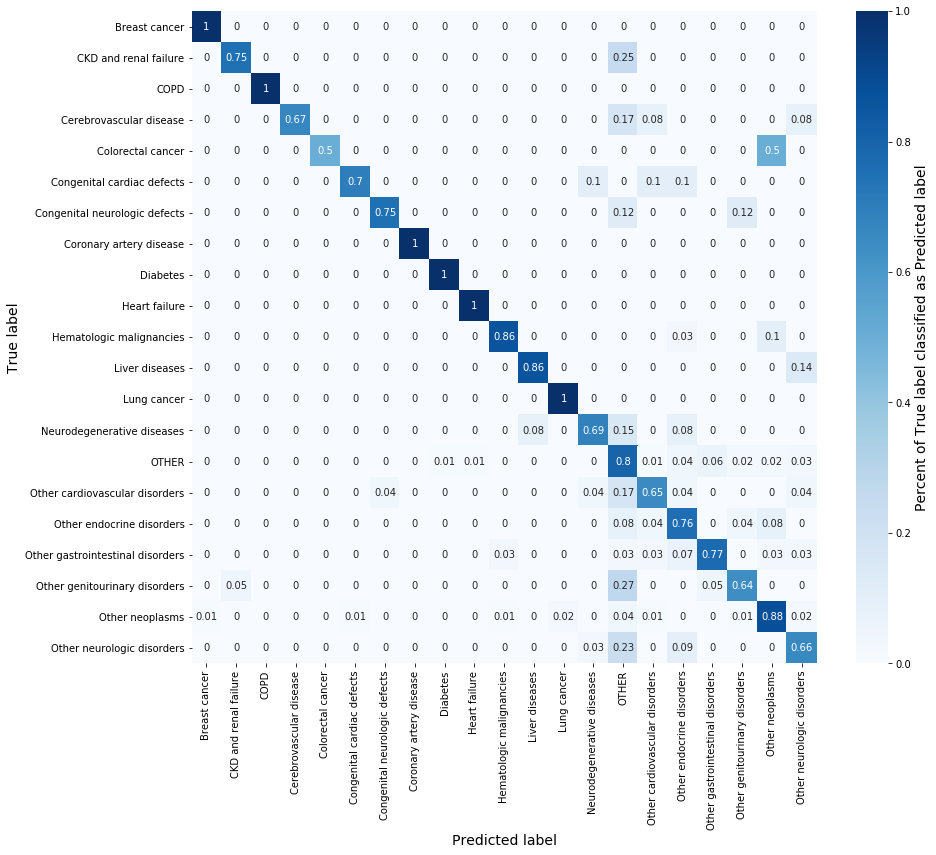

In [397]:
cm = confusion_matrix(y_true_clean_fit, y_pred_clean_fit, normalize='true')

#normalize to true to answer: "what percent of TRUE LABEL gets reclassified as PREDICTED LABEL"

import seaborn as sns
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = class_names, 
                     columns = class_names).round(2)

plt.figure(figsize=(14,12))
ax = sns.heatmap(cm_df, annot=True, cmap="Blues", cbar_kws={'label': 'Percent of True label classified as Predicted label'})
plt.ylabel('True label', size=14)
plt.xlabel('Predicted label', size=14)

cbar_axes = ax.figure.axes[-1]
ax.figure.axes[-1].yaxis.label.set_size(14)

plt.savefig("../data/cm.eps", bbox_inches='tight')

### Add intermediate category to data

Recode breast and lung cancer as above - takes a little while to run

In [398]:
breast_recode = []
for index,row in er_final.iterrows():
    if row['disease_category'] == 'Neoplasms':
        if pd.Series(row['chunks']).str.lower().str.contains('breast|breat|dcis|ductal').any():
            breast_recode.append(True)
        else:
            breast_recode.append(False)
    else:
        breast_recode.append(False)
        
lung_recode = []
for index,row in er_final.iterrows():
    if row['disease_category'] == 'Neoplasms':
        if pd.Series(row['chunks']).str.lower().str.contains('lung').any():
            lung_recode.append(True)
        else:
            lung_recode.append(False)
    else:
        lung_recode.append(False)

In [399]:
print('Number of breast cancer recoded: ', sum(breast_recode))
print('Number of lung cancer recoded: ', sum(lung_recode))

Number of breast cancer recoded:  7806
Number of lung cancer recoded:  2129


In [400]:
er_final.loc[breast_recode, 'int_category'] = 'Breast cancer'
er_final.loc[lung_recode, 'int_category'] = 'Lung cancer'

Rename intermediate categories that will not be used

In [401]:
er_final['int_category'].unique()

array(['Other endocrine disorders', 'Breast cancer',
       'Other injuries and external causes', 'Other neoplasms',
       'Cerebrovascular disease', 'Hematologic malignancies',
       'Other neurologic disorders', 'Other musculoskeletal disorders',
       'Lung cancer', 'Other respiratory disorders',
       'Other gastrointestinal disorders', 'Fractures',
       'Other genitourinary disorders', 'Other infections',
       'Rheumatologic disorders', 'Neurodegenerative diseases',
       'TBI and SCI', 'Other cardiovascular disorders', 'Heart failure',
       'Liver diseases', 'Diabetes', 'Other mental disorders',
       'CKD and renal failure', 'COPD', 'Substance use disorders',
       'Congenital neurologic defects', 'Congenital cardiac defects',
       'Coronary artery disease', 'HIV/AIDS', 'Colorectal cancer',
       'Prostate cancer'], dtype=object)

In [402]:
int_rename = {
    'Other mental disorders':'Mental and substance use disorders',
    'TBI and SCI':'Injuries and external causes',
    'Other injuries and external causes':'Injuries and external causes',
    'Other musculoskeletal disorders':'Musculoskeletal diseases',
    'Fractures':'Injuries and external causes',
    'Other infections':'Infections',
    'Rheumatologic disorders':'Musculoskeletal diseases',
    'Prostate cancer':'Other neoplasms',
    'Substance use disorders':'Mental and substance use disorders',
    'HIV/AIDS':'Infections'
}

In [403]:
er_final['int_category'].replace(int_rename, inplace=True)

### Pivot tables

In [404]:
print(er_final['url'].nunique())

65176


In [405]:
#add counts variables for pivot table
er_final['count'] = [1 for x in range(len(er_final))]

In [406]:
int_pivot = er_final[['url','int_category','count']].pivot_table(index=['url'], columns='int_category', values='count', aggfunc=(pd.Series.mean), fill_value=0)

In [407]:
disease_pivot = er_final[['url','disease_category','count']].pivot_table(index=['url'], columns='disease_category', values='count', aggfunc=(pd.Series.mean), fill_value=0)

In [408]:
print(int_pivot.shape)
print(disease_pivot.shape)

(65176, 25)
(65176, 11)


### Test that pivots worked

In [409]:
test_urls = ['https://www.gofundme.com/f/lana-medical-procedure','https://www.gofundme.com/f/2sv6wppg']

#first one should have Neuro and MSK (all neuro are other)
#second one should have just CV (cong and other)

In [410]:
disease_pivot[disease_pivot.index == test_urls[0]]

disease_category,Cardiovascular diseases,Endocrine diseases,Gastrointestinal diseases,Genitourinary diseases,Infections,Injuries and external causes,"Mental, behavioral, and substance use disorders",Musculoskeletal diseases,Neoplasms,Nervous system diseases,Respiratory diseases
url,,,,,,,,,,,
https://www.gofundme.com/f/lana-medical-procedure,0,0,0,0,0,0,0,1,0,1,0


In [411]:
disease_pivot[disease_pivot.index == test_urls[1]]

disease_category,Cardiovascular diseases,Endocrine diseases,Gastrointestinal diseases,Genitourinary diseases,Infections,Injuries and external causes,"Mental, behavioral, and substance use disorders",Musculoskeletal diseases,Neoplasms,Nervous system diseases,Respiratory diseases
url,,,,,,,,,,,
https://www.gofundme.com/f/2sv6wppg,1,0,0,0,0,0,0,0,0,0,0


In [412]:
int_pivot[int_pivot.index == test_urls[0]]

int_category,Breast cancer,CKD and renal failure,COPD,Cerebrovascular disease,Colorectal cancer,Congenital cardiac defects,Congenital neurologic defects,Coronary artery disease,Diabetes,Heart failure,...,Mental and substance use disorders,Musculoskeletal diseases,Neurodegenerative diseases,Other cardiovascular disorders,Other endocrine disorders,Other gastrointestinal disorders,Other genitourinary disorders,Other neoplasms,Other neurologic disorders,Other respiratory disorders
url,,,,,,,,,,,,,,,,,,,,,
https://www.gofundme.com/f/lana-medical-procedure,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [413]:
int_pivot[int_pivot.index == test_urls[1]]

int_category,Breast cancer,CKD and renal failure,COPD,Cerebrovascular disease,Colorectal cancer,Congenital cardiac defects,Congenital neurologic defects,Coronary artery disease,Diabetes,Heart failure,...,Mental and substance use disorders,Musculoskeletal diseases,Neurodegenerative diseases,Other cardiovascular disorders,Other endocrine disorders,Other gastrointestinal disorders,Other genitourinary disorders,Other neoplasms,Other neurologic disorders,Other respiratory disorders
url,,,,,,,,,,,,,,,,,,,,,
https://www.gofundme.com/f/2sv6wppg,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [414]:
print(disease_pivot['Infections'].sum())
print(int_pivot['Infections'].sum())

6055
6055


In [415]:
print(disease_pivot['Mental, behavioral, and substance use disorders'].sum())
print(int_pivot['Mental and substance use disorders'].sum())

3607
3607


In [416]:
print(disease_pivot['Musculoskeletal diseases'].sum())
print(int_pivot['Musculoskeletal diseases'].sum())

3897
3897


In [417]:
print(disease_pivot['Injuries and external causes'].sum())
print(int_pivot['Injuries and external causes'].sum())

5687
5687


In [418]:
print(disease_pivot['Neoplasms'].sum())
print(sum(int_pivot[['Other neoplasms','Colorectal cancer','Breast cancer','Lung cancer','Hematologic malignancies']].apply(lambda x: x.sum(), axis=1) > 0))

37201
37201


In [419]:
print(disease_pivot['Cardiovascular diseases'].sum())
print(sum(int_pivot[['Other cardiovascular disorders','Cerebrovascular disease','Congenital cardiac defects','Heart failure','Coronary artery disease']].apply(lambda x: x.sum(), axis=1) > 0))

10347
10347


In [420]:
print(disease_pivot['Nervous system diseases'].sum())
print(sum(int_pivot[['Other neurologic disorders','Neurodegenerative diseases','Congenital neurologic defects']].apply(lambda x: x.sum(), axis=1) > 0))

6596
6596


In [421]:
print(disease_pivot['Gastrointestinal diseases'].sum())
print(sum(int_pivot[['Other gastrointestinal disorders','Liver diseases']].apply(lambda x: x.sum(), axis=1) > 0))

4181
4181


In [422]:
print(disease_pivot['Endocrine diseases'].sum())
print(sum(int_pivot[['Other endocrine disorders','Diabetes']].apply(lambda x: x.sum(), axis=1) > 0))

3243
3243


In [423]:
print(disease_pivot['Respiratory diseases'].sum())
print(sum(int_pivot[['Other respiratory disorders','COPD']].apply(lambda x: x.sum(), axis=1) > 0))

4495
4495


In [424]:
print(disease_pivot['Genitourinary diseases'].sum())
print(sum(int_pivot[['Other genitourinary disorders','CKD and renal failure']].apply(lambda x: x.sum(), axis=1) > 0))

4476
4476


### Get primary category

Summarize by disease category and location of chunk in text

In [ ]:
#er_final = er_final.reset_index()

In [425]:
%%time
er_cat = er_final[['url','begin','disease_category','int_category']].groupby(['url']).agg(list)

CPU times: user 14.3 s, sys: 319 ms, total: 14.6 s
Wall time: 14.9 s


In [426]:
from collections import Counter

In [427]:
#get counts for each category
er_cat['disease_category_count'] = er_cat['disease_category'].apply(lambda x: Counter(x).most_common())
er_cat['int_category_count'] = er_cat['int_category'].apply(lambda x: Counter(x).most_common())

In [428]:
#separate counts into separate column
er_cat['disease_category_count_max'] = [x[0][1] for x in er_cat['disease_category_count']]
er_cat['int_category_count_max'] = [x[0][1] for x in er_cat['int_category_count']]

In [429]:
#explode
exl_d = er_cat.explode('disease_category_count')
exl_i = er_cat.explode('int_category_count')

In [430]:
#separate tuples
exl_d['disease_cat'] = [x[0] for x in exl_d['disease_category_count']]
exl_d['disease_cat_val'] = [x[1] for x in exl_d['disease_category_count']]

exl_i['int_cat'] = [x[0] for x in exl_i['int_category_count']]
exl_i['int_cat_val'] = [x[1] for x in exl_i['int_category_count']]

In [431]:
#remove categories that do not have max amount
exl_d = exl_d[exl_d['disease_cat_val'] == exl_d['disease_category_count_max']]
exl_i = exl_i[exl_i['int_cat_val'] == exl_i['int_category_count_max']]

In [432]:
#reset indices
exl_d = exl_d.reset_index()
exl_i = exl_i.reset_index()

In [433]:
#separate urls that are duplicated (those who have multiple categories equal to max count)
exl_d_dup = exl_d[exl_d['url'].duplicated(keep=False)]
exl_i_dup = exl_i[exl_i['url'].duplicated(keep=False)]

#separate urls that are not duplicated
exl_d_no_dup = exl_d[~exl_d['url'].duplicated(keep=False)]
exl_i_no_dup = exl_i[~exl_i['url'].duplicated(keep=False)]

print(exl_d_dup.shape)
print(exl_i_dup.shape)

print(exl_d_no_dup.shape)
print(exl_i_no_dup.shape)

(13162, 10)
(22877, 10)
(59238, 10)
(54890, 10)


In [434]:
def GetPrimaryCat(df, first_col, second_col):

    r = {}

    for url in df['url']:
        sub = df[df['url'] == url]
        candidates = sub[sub['url'] == url][first_col].tolist()
        pos = sub[sub['url'] == url].drop_duplicates('url')['begin'].tolist()[0]
        cats = sub[sub['url'] == url].drop_duplicates('url')[second_col].tolist()[0]
        new_df = pd.DataFrame({'cats':cats, 'pos':pos})
        new_df = new_df[new_df['cats'].isin(candidates)]
        final_cat = new_df.groupby('cats').agg('mean').reset_index().sort_values('pos', ascending=True)['cats'].tolist()[0]

        r[url] = final_cat
    
    return r

In [435]:
%%time
primary_disease_map = GetPrimaryCat(exl_d_dup,'disease_cat','disease_category') 

CPU times: user 2min 14s, sys: 2.06 s, total: 2min 16s
Wall time: 2min 30s


In [436]:
%%time
primary_int_map = GetPrimaryCat(exl_i_dup,'int_cat','int_category')

CPU times: user 4min 38s, sys: 5.94 s, total: 4min 44s
Wall time: 5min 24s


In [437]:
def SubsetPrimaryCat(df, subset_map, col):
    
    r = []
    
    for k,v in subset_map.items():
        sub = df[df['url'] == k]
        sub = sub[sub[col] == v]
        r.append(sub)
    
    return pd.concat(r)    

In [438]:
%%time
exl_d_dup_primary = SubsetPrimaryCat(exl_d_dup, primary_disease_map, 'disease_cat')

CPU times: user 13.5 s, sys: 622 ms, total: 14.1 s
Wall time: 14.8 s


In [439]:
%%time
exl_i_dup_primary = SubsetPrimaryCat(exl_i_dup, primary_int_map, 'int_cat')

CPU times: user 34 s, sys: 537 ms, total: 34.5 s
Wall time: 37 s


In [440]:
#concatenate primary results from duplicated
primary_disease = pd.concat([exl_d_no_dup,exl_d_dup_primary])
primary_int = pd.concat([exl_i_no_dup,exl_i_dup_primary])

In [441]:
print(primary_disease.shape)
print(primary_int.shape)

(65176, 10)
(65176, 10)


In [442]:
primary_category = pd.merge(primary_disease[['url','disease_cat']], primary_int[['url','int_cat']], on='url', how='left')

### Export data

In [164]:
import sqlite3

In [443]:
conn = sqlite3.connect("../data/db/gfm.db")

In [444]:
er_final.to_sql('er_final', con=conn,if_exists='replace')

In [446]:
disease_pivot = disease_pivot.reset_index()
disease_pivot.columns.name = ''
cols = disease_pivot.columns
cols = [x.lower().replace(',','').replace(' ','_') for x in cols]
disease_pivot.columns = cols

disease_pivot.to_sql('disease_pivot', con=conn, if_exists='replace')

In [447]:
int_pivot.reset_index()
int_pivot.columns.name = ''
cols = int_pivot.columns
cols = [x.lower().replace(',','').replace(' ','_') for x in cols]
int_pivot.columns = cols

int_pivot.to_sql('int_pivot', con=conn, if_exists='replace')

In [448]:
primary_category.to_sql('primary_cat', con=conn, if_exists='replace')